In [1]:
# https://datascience.stackexchange.com/questions/33364/why-model-fit-generator-in-keras-is-taking-so-much-time-even-before-picking-the
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [2]:
from pathlib import Path
from glob import glob
import numpy as np
import pandas as pd

In [3]:
import torch
import torch.nn as nn
from functools import reduce
from torch.autograd import Variable

In [4]:
from skimage.io import imread
from skimage.transform import resize
import tensorflow.keras as keras
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, ReLU, Dropout, 
                                     Flatten, GlobalAveragePooling2D)
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

In [5]:
import warnings

warnings.filterwarnings("ignore")

# PyTorch to Keras

The original model (including pre-trained weights) was in Torch7/Caffe. I choose to first convert the Torch7 model to PyTorch since there's currently no API to convert from Torch to TensorFlow directly.

## Build model in PyTorch and load pre-trained weights

This part is the output of the [`convert_torch_to_pytorch`](https://github.com/clcarwin/convert_torch_to_pytorch) API.

In [ ]:
class LambdaBase(nn.Sequential):
    def __init__(self, fn, *args):
        super(LambdaBase, self).__init__(*args)
        self.lambda_func = fn

    def forward_prepare(self, input):
        output = []
        for module in self._modules.values():
            output.append(module(input))
        return output if output else input

class Lambda(LambdaBase):
    def forward(self, input):
        return self.lambda_func(self.forward_prepare(input))

class LambdaMap(LambdaBase):
    def forward(self, input):
        return list(map(self.lambda_func,self.forward_prepare(input)))

class LambdaReduce(LambdaBase):
    def forward(self, input):
        return reduce(self.lambda_func,self.forward_prepare(input))

In the model architecture, I have to change all the `ceil_mode=True` in MaxPool2d layers to `ceil_mode=False` because the `pytorch2keras` API (onnx) doesn't support this option.

In [ ]:
pytorch_model = nn.Sequential( # Sequential,
    nn.Conv2d(3, 64, (3, 3),(1, 1),(1, 1)),
    nn.ReLU(),
    nn.Conv2d(64,64,(3, 3),(1, 1),(1, 1)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0),ceil_mode=False),

    nn.Conv2d(64,128,(3, 3),(1, 1),(1, 1)),
    nn.ReLU(),
    nn.Conv2d(128,128,(3, 3),(1, 1),(1, 1)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0),ceil_mode=False),

    nn.Conv2d(128,256,(3, 3),(1, 1),(1, 1)),
    nn.ReLU(),
    nn.Conv2d(256,256,(3, 3),(1, 1),(1, 1)),
    nn.ReLU(),
    nn.Conv2d(256,256,(3, 3),(1, 1),(1, 1)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0),ceil_mode=False),

    nn.Conv2d(256,512,(3, 3),(1, 1),(1, 1)),
    nn.ReLU(),
    nn.Conv2d(512,512,(3, 3),(1, 1),(1, 1)),
    nn.ReLU(),
    nn.Conv2d(512,512,(3, 3),(1, 1),(1, 1)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0),ceil_mode=False),

    nn.Conv2d(512,512,(3, 3),(1, 1),(1, 1)),
    nn.ReLU(),
    nn.Conv2d(512,512,(3, 3),(1, 1),(1, 1)),
    nn.ReLU(),
    nn.Conv2d(512,512,(3, 3),(1, 1),(1, 1)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0),ceil_mode=False),

    Lambda(lambda x: x.view(x.size(0), -1)), # View,
    nn.Sequential(Lambda(lambda x: x.view(1,-1) if 1==len(x.size()) else x ),nn.Linear(25088,4096)), # Linear,
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Sequential(Lambda(lambda x: x.view(1,-1) if 1==len(x.size()) else x ),nn.Linear(4096,4096)), # Linear,
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Sequential(Lambda(lambda x: x.view(1,-1) if 1==len(x.size()) else x ),nn.Linear(4096,2622)), # Linear,
    nn.Softmax()
)

In [ ]:
pytorch_model.load_state_dict(torch.load('./pytorch_ver/VGG_FACE.pth'))

In [ ]:
# first remove Dropout and Softmax layers because onnx does not support these two layers yet
pytorch_model = nn.Sequential(pytorch_model[:34], pytorch_model[35:37], pytorch_model[38])

In [ ]:
torch.save(pytorch_model.state_dict(), 'pytorch_model.pth')

## Convert to Keras weights with `pytorch2keras`

In [ ]:
# create a dummy variable with correct shape
input_np = np.random.uniform(0, 1, (1, 3, 224, 224))
input_var = Variable(torch.FloatTensor(input_np))

In [ ]:
from pytorch2keras import pytorch_to_keras

# we should specify shape of the input tensor
k_model = pytorch_to_keras(pytorch_model, input_var, verbose=True)  

### Save Keras weights

In [ ]:
k_model.save_weights('./keras_weights.h5')

# Re-build the VGGFace model in TensorFlow with pre-trained weights

Build model in TensorFlow(Keras) according to the PyTorch model architecture.

In [ ]:
kernel_config = [64, 128, 256, 512, 512]
layer_config = [2, 2, 3, 3, 3]

In [ ]:
def build_model(kernel_config, layer_config):
    inputs = keras.Input(shape=(3, 224, 224))
    x = inputs
    
    # add vgg blocks
    for i in range(len(layer_config)):
        for j in range(layer_config[i]):
            kernel_size = kernel_config[i]
            x = Conv2D(kernel_size, (3, 3), (1, 1), activation='relu', data_format='channels_first',
                       padding='same', name=f'block{i+1}_conv{j+1}')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), data_format='channels_first',
                         name=f'block{i+1}_pool')(x)
    
    # add lambda layers
    x = Flatten(data_format='channels_first', name='flatten')(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2622)(x)
    
    # define model
    model = keras.Model(inputs=inputs, outputs=predictions)
    
#     model.compile(loss='binary_crossentropy', 
#                   optimizer=keras.optimizers.Adam(5e-3), 
#                   metrics=['accuracy'])
    
    return model

In [ ]:
model = build_model(kernel_config, layer_config)
# model.summary()

## Load pre-trained weights

In [ ]:
model.load_weights('./keras_weights.h5')

## Add Dense layer for gender classification

Add Dense layers to build a gender classification model based on the pre-trained VGG-Face model.

In [ ]:
# Store the fully connected layers
fc = model.get_layer('dense_1')

# change the output layer
fc_out = Dense(1, activation='sigmoid', name='output')

# Reconnect the layers
x = fc.output
predictions = fc_out(x)

# Create a new model
gender_model = keras.Model(inputs=model.input, outputs=predictions)

In [ ]:
# freeze the pre-trained weights
for layer in gender_model.layers[:-1]:
    layer.trainable = False

# Train the gender classifier

The data I used is downloaded here: https://s3.amazonaws.com/matroid-web/datasets/agegender_cleaned.tar.gz

I use the `aligned/` folder as training set and the `valid/` folder as validation set.

## Data preparation

In [6]:
img_path = Path('./data/combined/')

In [7]:
train_paths_F = glob(str(img_path/'aligned/*F/*.jpg'), recursive=True)
train_paths_M = glob(str(img_path/'aligned/*M/*.jpg'), recursive=True)
val_paths_F = glob(str(img_path/'valid/*F/*.jpg'), recursive=True)
val_paths_M = glob(str(img_path/'valid/*M/*.jpg'), recursive=True)

In [8]:
len(train_paths_F), len(train_paths_M), len(val_paths_F), len(val_paths_M)

(14312, 15125, 1752, 1929)

Label - Female: 0, Male: 1

In [22]:
# make train df
train_df_F = pd.DataFrame(train_paths_F, columns=['fpath'])
train_df_F['gender'] = 'f'

train_df_M = pd.DataFrame(train_paths_M, columns=['fpath'])
train_df_M['gender'] = 'm'

train_df = pd.concat([train_df_F, train_df_M], axis=0)
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [23]:
# make val df
val_df_F = pd.DataFrame(val_paths_F, columns=['fpath'])
val_df_F['gender'] = 'f'

val_df_M = pd.DataFrame(val_paths_M, columns=['fpath'])
val_df_M['gender'] = 'm'

val_df = pd.concat([val_df_F, val_df_M], axis=0)
val_df = val_df.sample(frac=1).reset_index(drop=True)

In [24]:
train_df.shape, val_df.shape

((29437, 2), (3681, 2))

## Data Generator

In [66]:
batch_size = 64

In [67]:
train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.3,
        horizontal_flip=True,
        data_format='channels_first')
val_datagen = ImageDataGenerator(data_format='channels_first')

train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='fpath',
        y_col='gender',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')
val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='fpath',
        y_col='gender',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

Found 29437 validated image filenames belonging to 2 classes.
Found 3681 validated image filenames belonging to 2 classes.


In [14]:
X, y = next(iter(train_generator))

In [15]:
X.shape, y.shape

((64, 3, 224, 224), (64,))

1.0


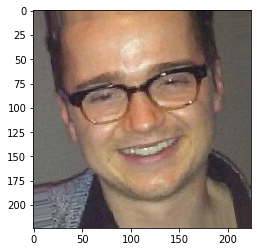

In [17]:
# check data
import matplotlib.pyplot as plt

plt.imshow(X[1].transpose(1, 2, 0).astype(int))
print(y[1])

# Train Model

In [ ]:
num_epochs = 10
# learning_rate = 1e-2
# decay_rate = learning_rate / num_epochs
# momentum = 0.85
# sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

gender_model.compile(loss='binary_crossentropy', 
                     optimizer='adam', 
                     metrics=['accuracy'])
gender_model.summary()

In [ ]:
gender_model_history = gender_model.fit_generator(generator=train_generator,
#                                                   steps_per_epoch=100,
                                                  epochs=num_epochs,
                                                  verbose=1,
                                                  validation_data=val_generator,
                                                  use_multiprocessing=True,
                                                  workers=4,
                                                  max_queue_size=16)

In [ ]:
# gender_model.save('gender_cls_model.h5')

# Test model

In [18]:
# Recreate the exact same model, including weights and optimizer.
gender_model = keras.models.load_model('gender_cls_model.h5')
gender_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 224, 224)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 224, 224)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 112, 112)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 112, 112)     73856     
_______________________________________

In [19]:
gender_model.evaluate_generator(val_generator,
                                use_multiprocessing=True,
                                max_queue_size=10,
                                workers=4,
                                verbose=1)

58/58 [==============================] - 41s 701ms/step - loss: 0.2765 - acc: 0.8788


[0.27646446407868946, 0.8788373]

In [77]:
val_generator_all = val_datagen.flow_from_dataframe(
                    val_df,
                    x_col='fpath',
                    y_col='gender',
                    target_size=(224, 224),
                    batch_size=val_df.shape[0],
                    class_mode='binary')

Found 3681 validated image filenames belonging to 2 classes.


In [80]:
X, y = next(iter(val_generator_all))
pred = gender_model.predict(X, verbose=1)
pred = pred.squeeze()

3681/3681 [==============================] - 32s 9ms/sample


In [81]:
X.shape, y.shape, pred.shape

((3681, 3, 224, 224), (3681,), (3681,))

In [84]:
pred = [1 if p > 0.5 else 0 for p in pred]

In [87]:
from sklearn.metrics import classification_report

print(classification_report(y, pred, target_names=['Female', 'Male']))

              precision    recall  f1-score   support

      Female       0.91      0.83      0.87      1752
        Male       0.86      0.92      0.89      1929

    accuracy                           0.88      3681
   macro avg       0.88      0.88      0.88      3681
weighted avg       0.88      0.88      0.88      3681

